### Author: Antoni Kowalczuk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import json
import os


In [2]:
def decode_experiment_name(name: str) -> dict:
    return {
        key: [value]
        for key, value in zip(
            ["dataset", "rows_per_clf_perc", "clfs_cnt", "svm_perc", "svm_kernel"],
            name.split("_"),
        )
    }


In [3]:
def get_accuracy_per_class(confusion_matrix: np.ndarray) -> float:
    tps = confusion_matrix.diagonal()
    ps = confusion_matrix.sum(axis=1)
    acc = tps / ps
    acc[np.isnan(acc)] = 0
    return acc.sum() / len(acc)


In [4]:
def get_bulk_accuracies(experiment: dict) -> tuple:
    accuracies, accuracies_per_class = [], []
    for results in experiment.values():
        acc, cm = results
        accuracies.append(acc)
        accuracies_per_class.append(get_accuracy_per_class(cm))
    return np.array(accuracies), np.array(accuracies_per_class)


In [5]:
def process_results(results: dict) -> pd.DataFrame:
    dfs = []
    for experiment_name, experiment in results.items():
        exp_dict = decode_experiment_name(experiment_name)
        accuracies, accuracies_per_class = get_bulk_accuracies(experiment)
        for agg_name, agg_func in zip(
            ["mean", "std", "min", "max"], [np.mean, np.std, np.min, np.max]
        ):
            for acc_name, acc_array in zip(
                ["accuracy", "accuracy_per_class"], [accuracies, accuracies_per_class]
            ):
                exp_dict[f"{agg_name}_{acc_name}"] = agg_func(acc_array)
        dfs.append(pd.DataFrame.from_dict(exp_dict))
    df = pd.concat(dfs, axis=0)
    return df


In [6]:
from itertools import product

METRICS = [
    f"{agg_name}_{acc_name}"
    for agg_name, acc_name in product(
        ["mean", "std", "min", "max"], ["accuracy", "accuracy_per_class"]
    )
]
HYPERPARAMS = ["rows_per_clf_perc", "clfs_cnt", "svm_perc", "svm_kernel"]


In [7]:
def get_plots(df: pd.DataFrame, type_: str = "grid"):
    _, axs = plt.subplots(2, 2, figsize=(20, 10))
    axs = axs.flatten()
    for idx, hyperparam in enumerate(HYPERPARAMS):
        a = axs[idx]
        if type_ == "grid":
            df.groupby(hyperparam)[METRICS].mean().T.plot.bar(edgecolor="black", ax=a)
            a.set_xticklabels(a.get_xticklabels(), rotation=45)
        elif type_ == "random":
            tmp_df = (
                df.loc[:, [hyperparam] + METRICS].set_index(hyperparam).sort_index()
            )
            xticklabels = tmp_df.index.tolist()
            tmp_df.plot(ax=a)
            a.set_xticks(np.arange(len(xticklabels)))
            a.set_xticklabels(xticklabels, rotation=45)
        a.set_title(hyperparam)
    plt.show()


In [8]:
with open(os.path.join("results", "random_search.pickle"), "rb") as f_obj:
    rs_results = pkl.load(f_obj)

with open(os.path.join("results", "id3_search.pickle"), "rb") as f_obj:
    id3_results = pkl.load(f_obj)

with open(os.path.join("results", "svm_search.pickle"), "rb") as f_obj:
    svm_results = pkl.load(f_obj)


# Dataset cars

## GridSearch

In [9]:
with open(os.path.join("results", "car", "grid_search.pickle"), "rb") as f_obj:
    cars_results = pkl.load(f_obj)


In [10]:
df = process_results(cars_results)
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((400, 13), 0.7004274999999999, 0.25000154158142324)

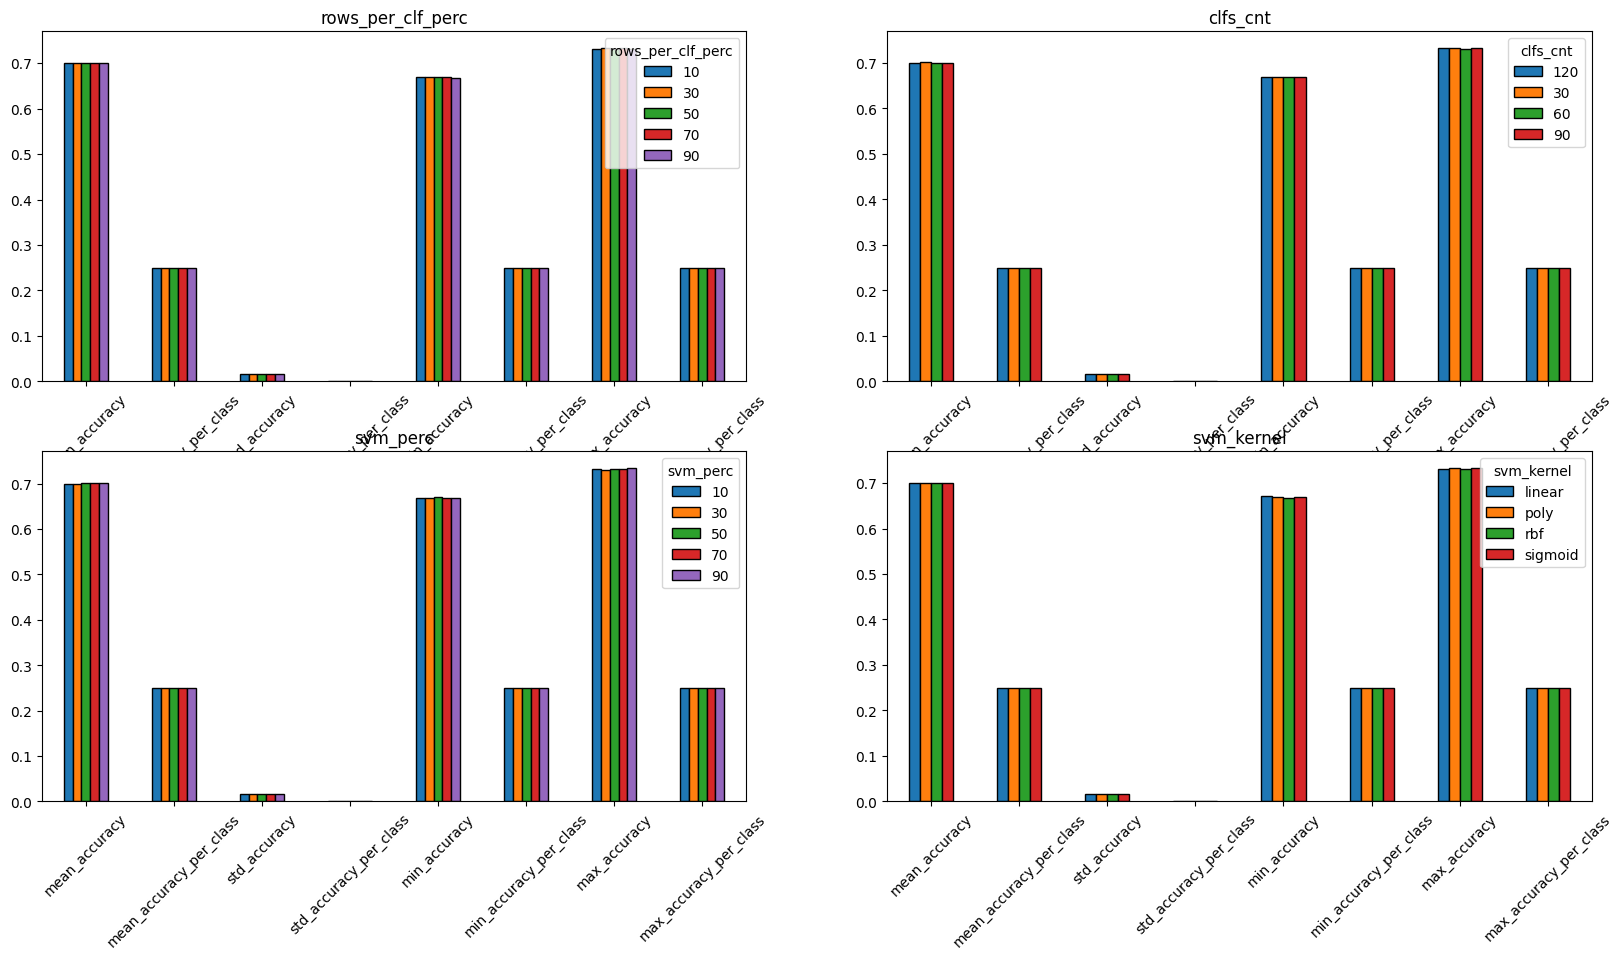

In [11]:
get_plots(df, type_='grid')

## RandomSearch

In [12]:
df = process_results(rs_results)
df = df.loc[df.dataset=='car', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((25, 13), 0.7005999999999999, 0.25)

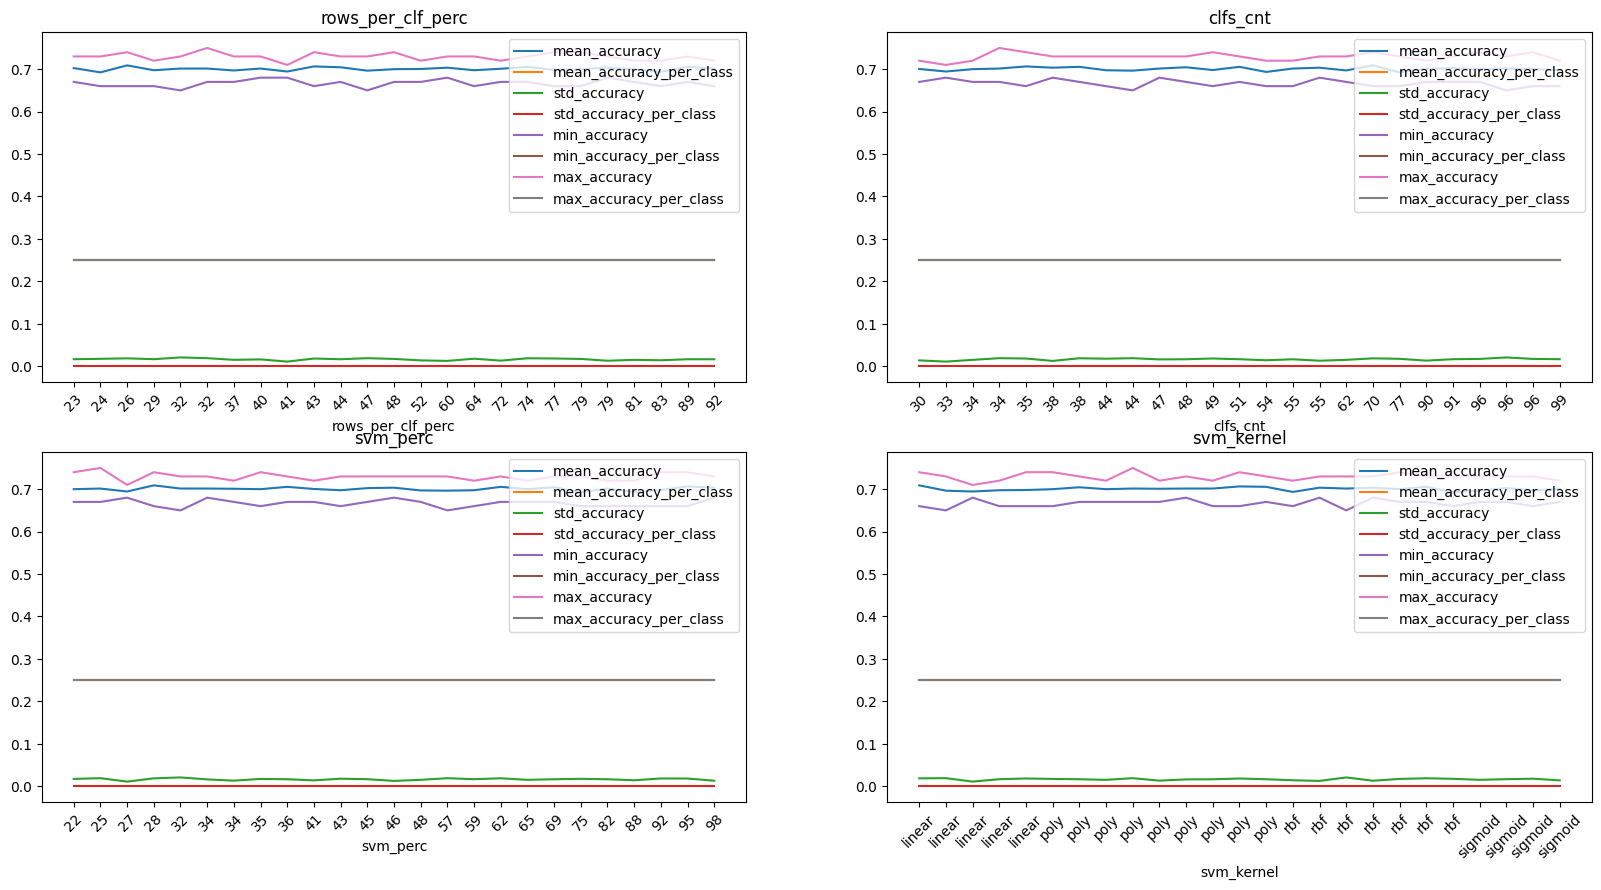

In [13]:
get_plots(df, type_='random')

## ID3

In [14]:
df = process_results(id3_results)
df = df.loc[df.dataset=='car', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((20, 13), 0.699975, 0.25)

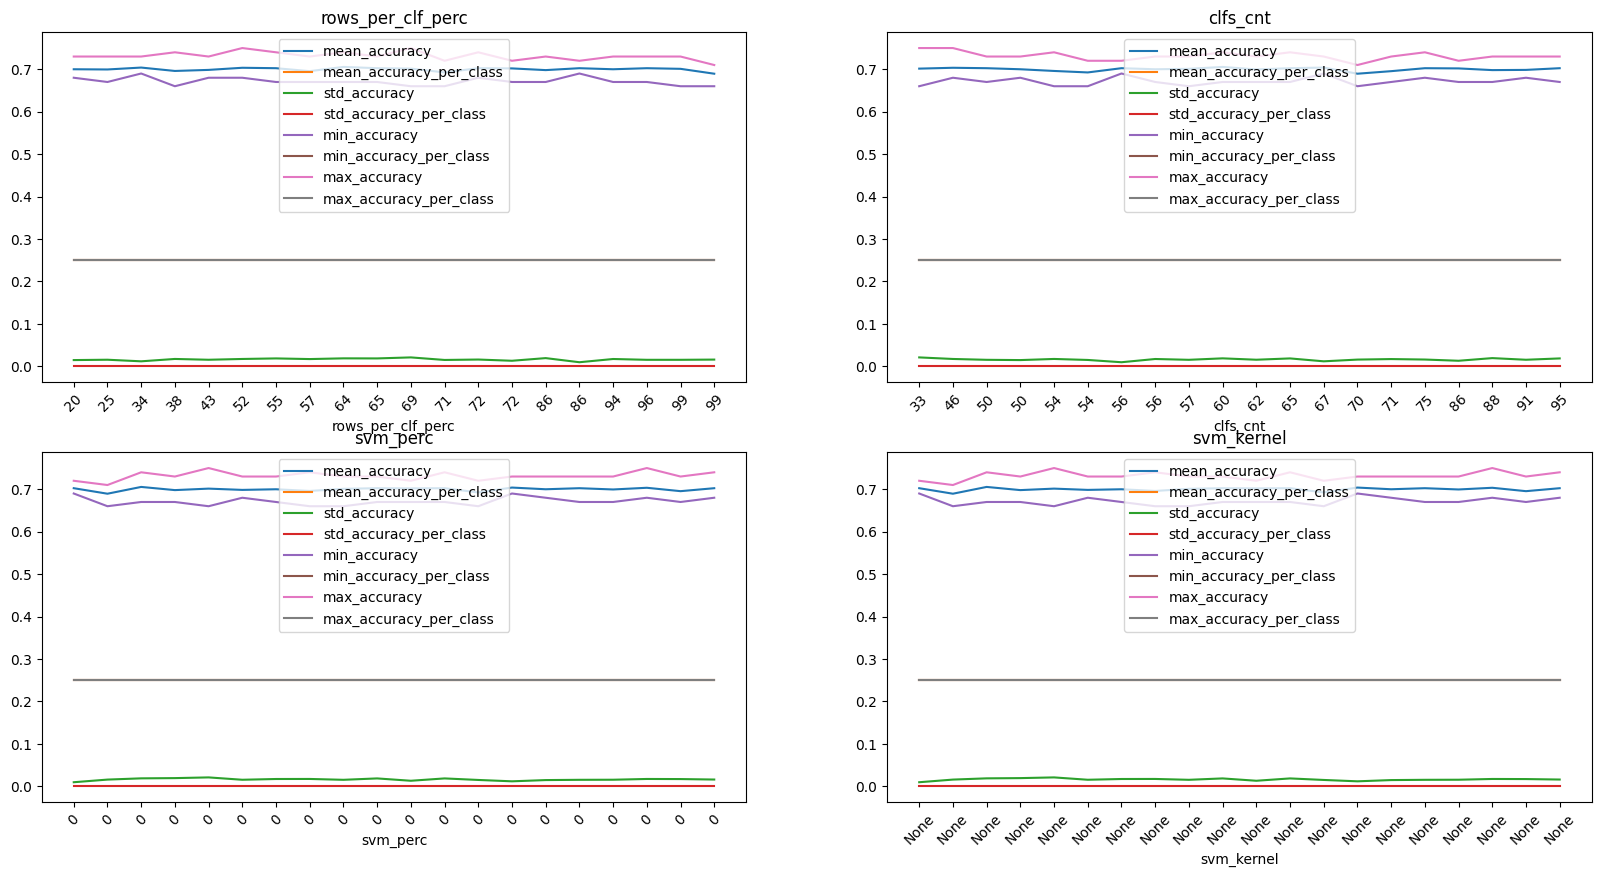

In [15]:
get_plots(df, type_='random')

In [16]:
df = process_results(svm_results)
df = df.loc[df.dataset=='car', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((25, 13), 0.7013999999999999, 0.25)

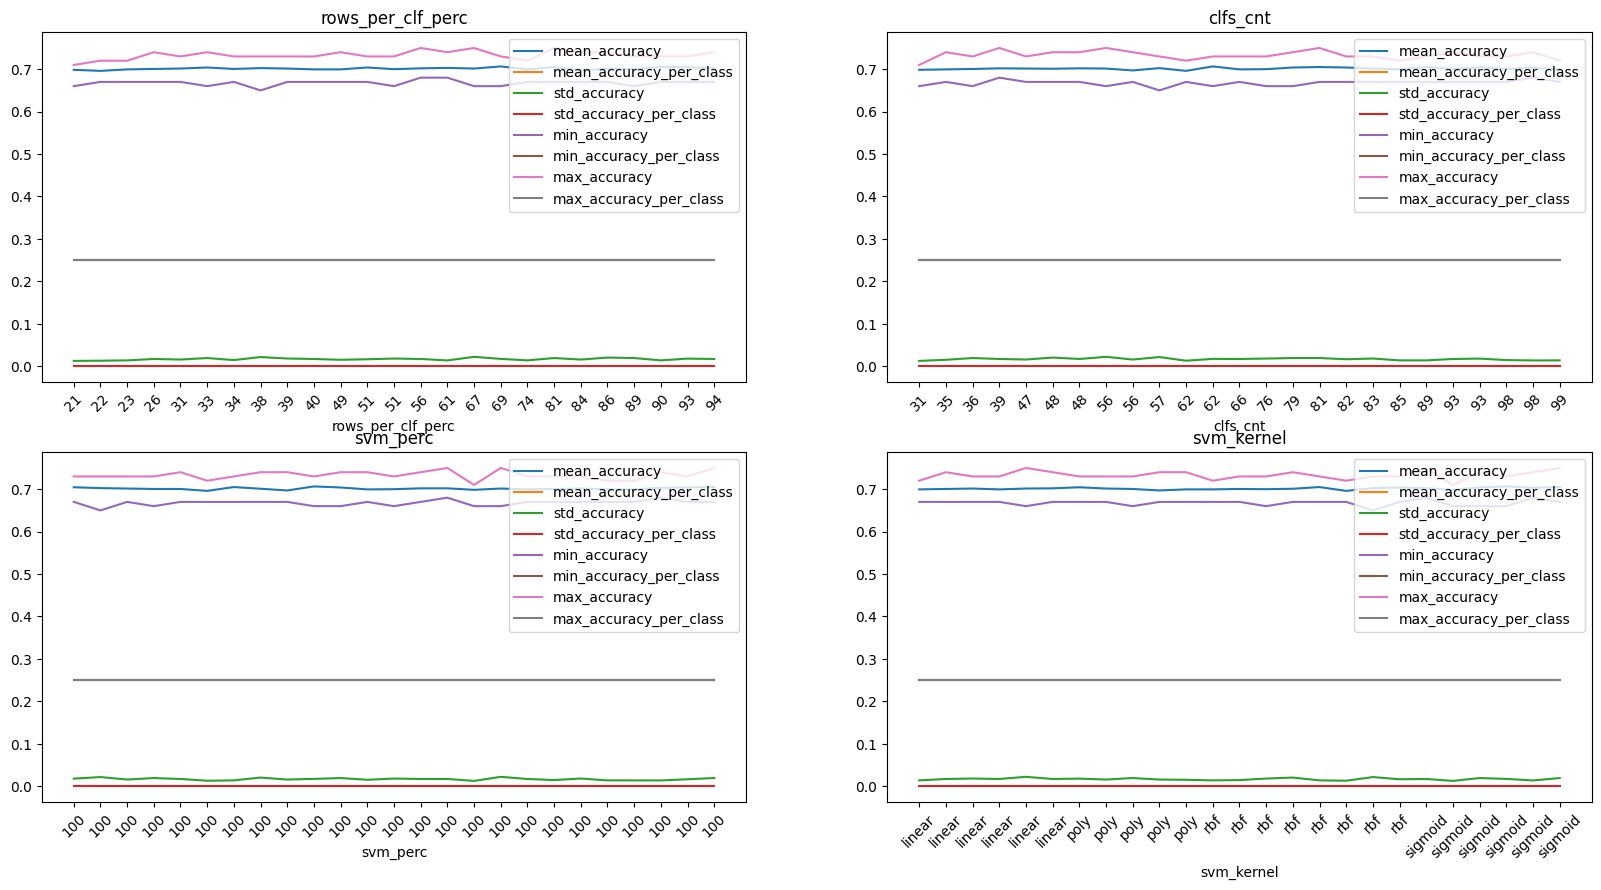

In [17]:
get_plots(df, type_='random')

## GridSearch

In [18]:
with open(os.path.join("results", "car", "grid_search.pickle"), "rb") as f_obj:
    cars_results = pkl.load(f_obj)


In [19]:
df = process_results(cars_results)
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((400, 13), 0.7004274999999999, 0.25000154158142324)

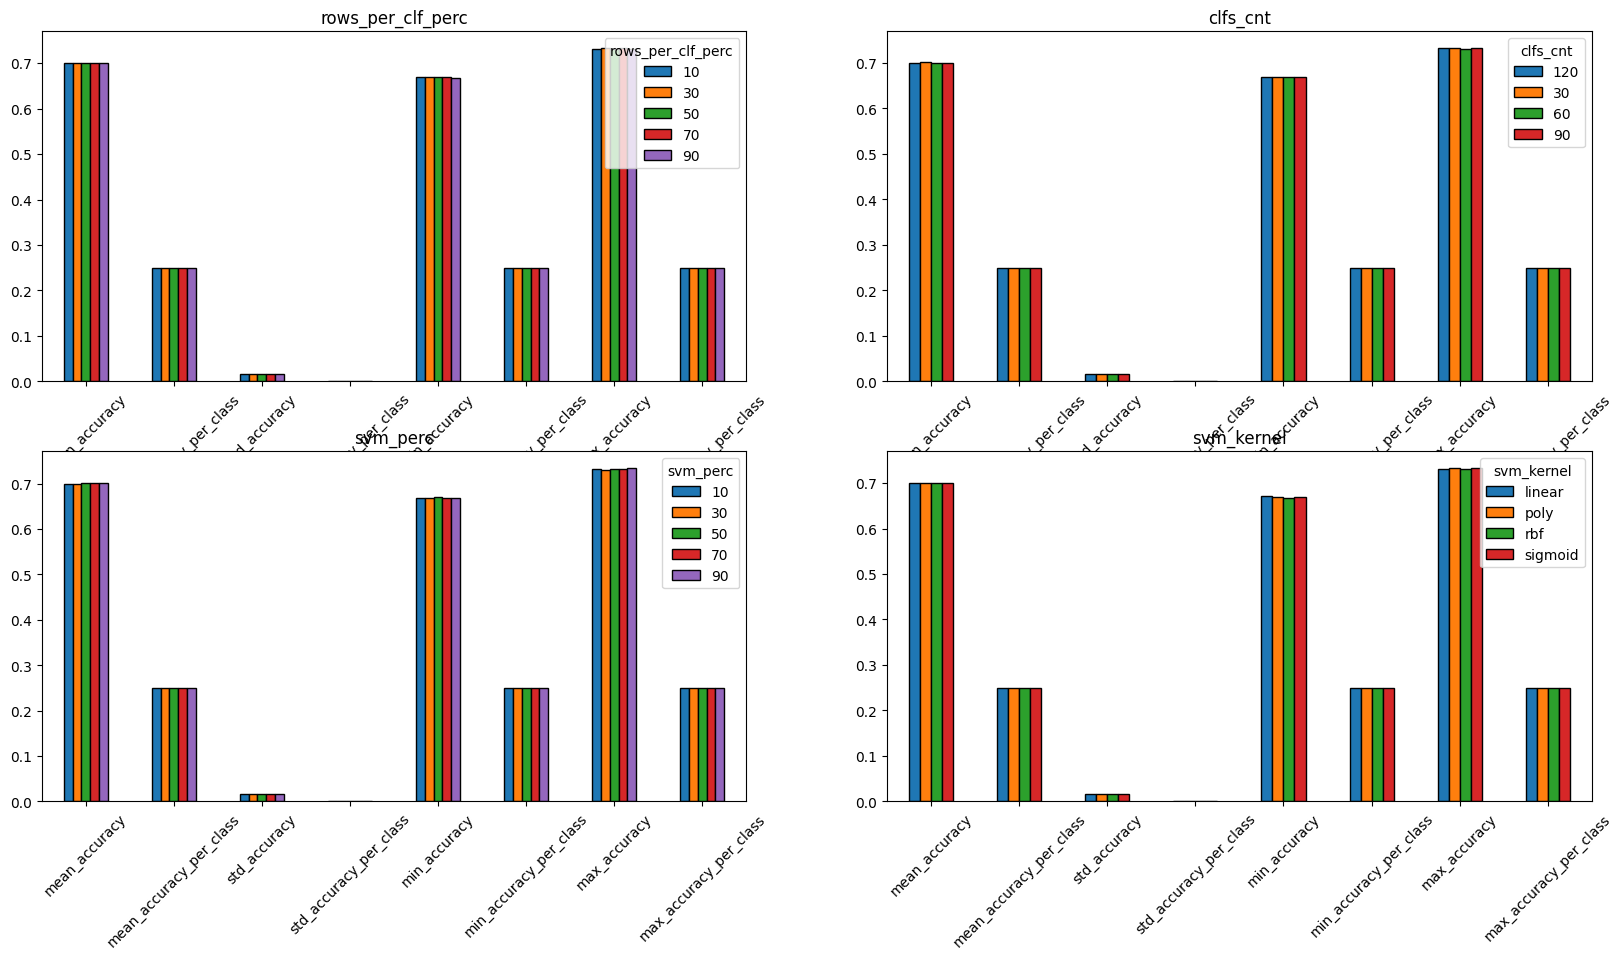

In [20]:
get_plots(df, type_='grid')

## Wyniki

Okazuje się, że przez niezbalansowane klasy modele nauczyły się jedynie przewidywać najliczniejszą z klas. Z tego powodu nie jesteśmy w stanie porównać różnych zestawów hiperparametrów do siebie

# Dataset divorce

## RandomSearch

In [21]:
df = process_results(rs_results)
df = df.loc[df.dataset=='divorce', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((25, 13), 0.9545800000000001, 0.955804628947893)

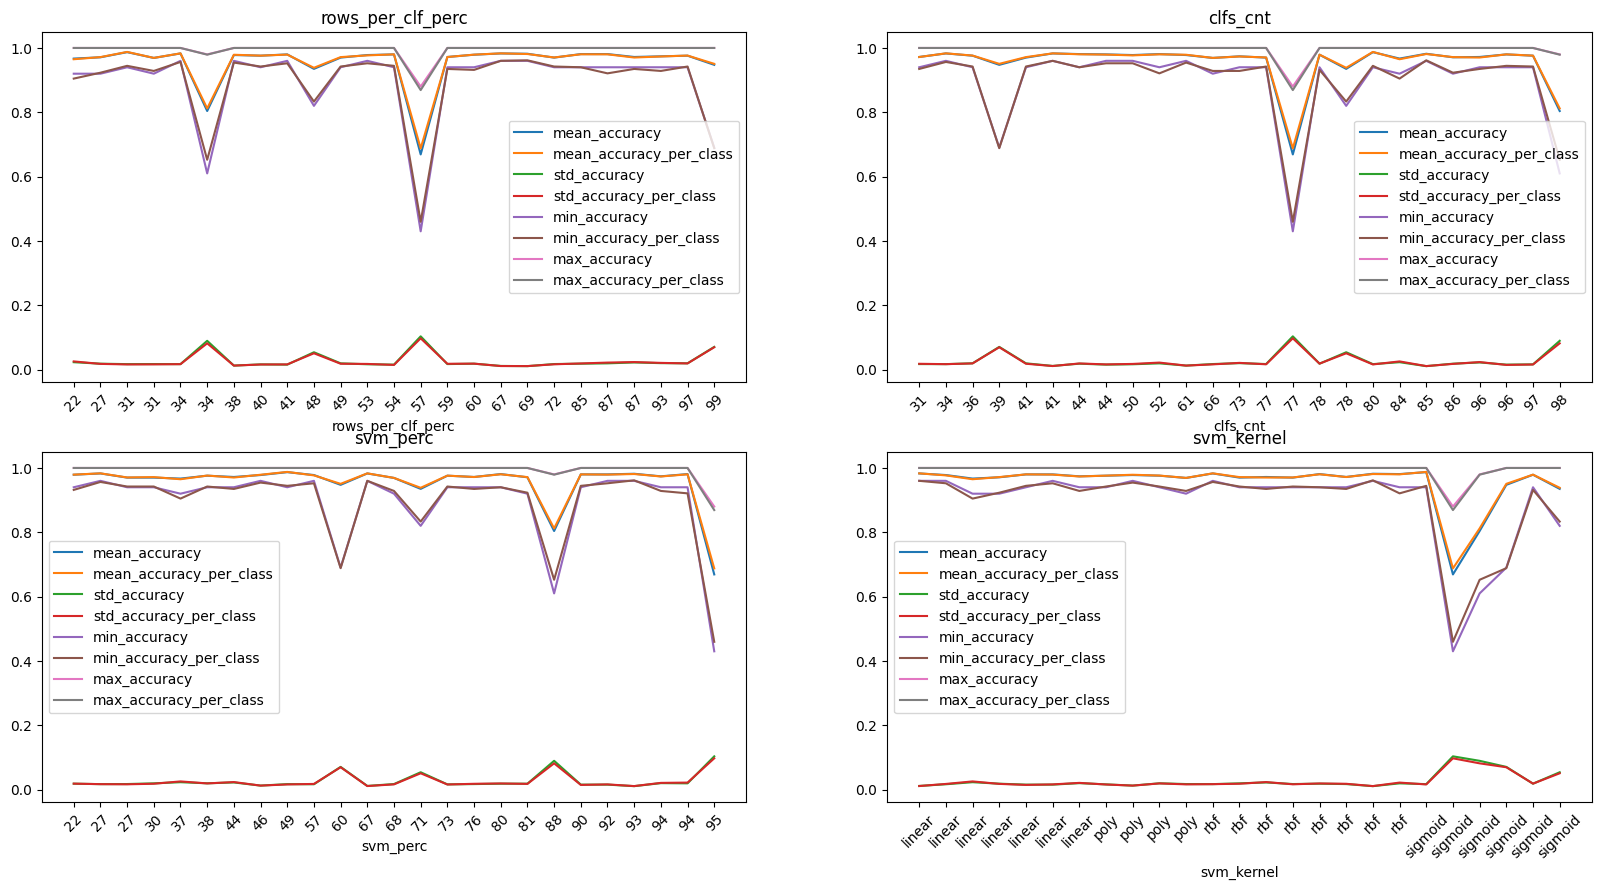

In [22]:
get_plots(df, type_='random')

## ID3

In [23]:
df = process_results(id3_results)
df = df.loc[df.dataset=='divorce', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((20, 13), 0.9743499999999999, 0.9744139286682902)

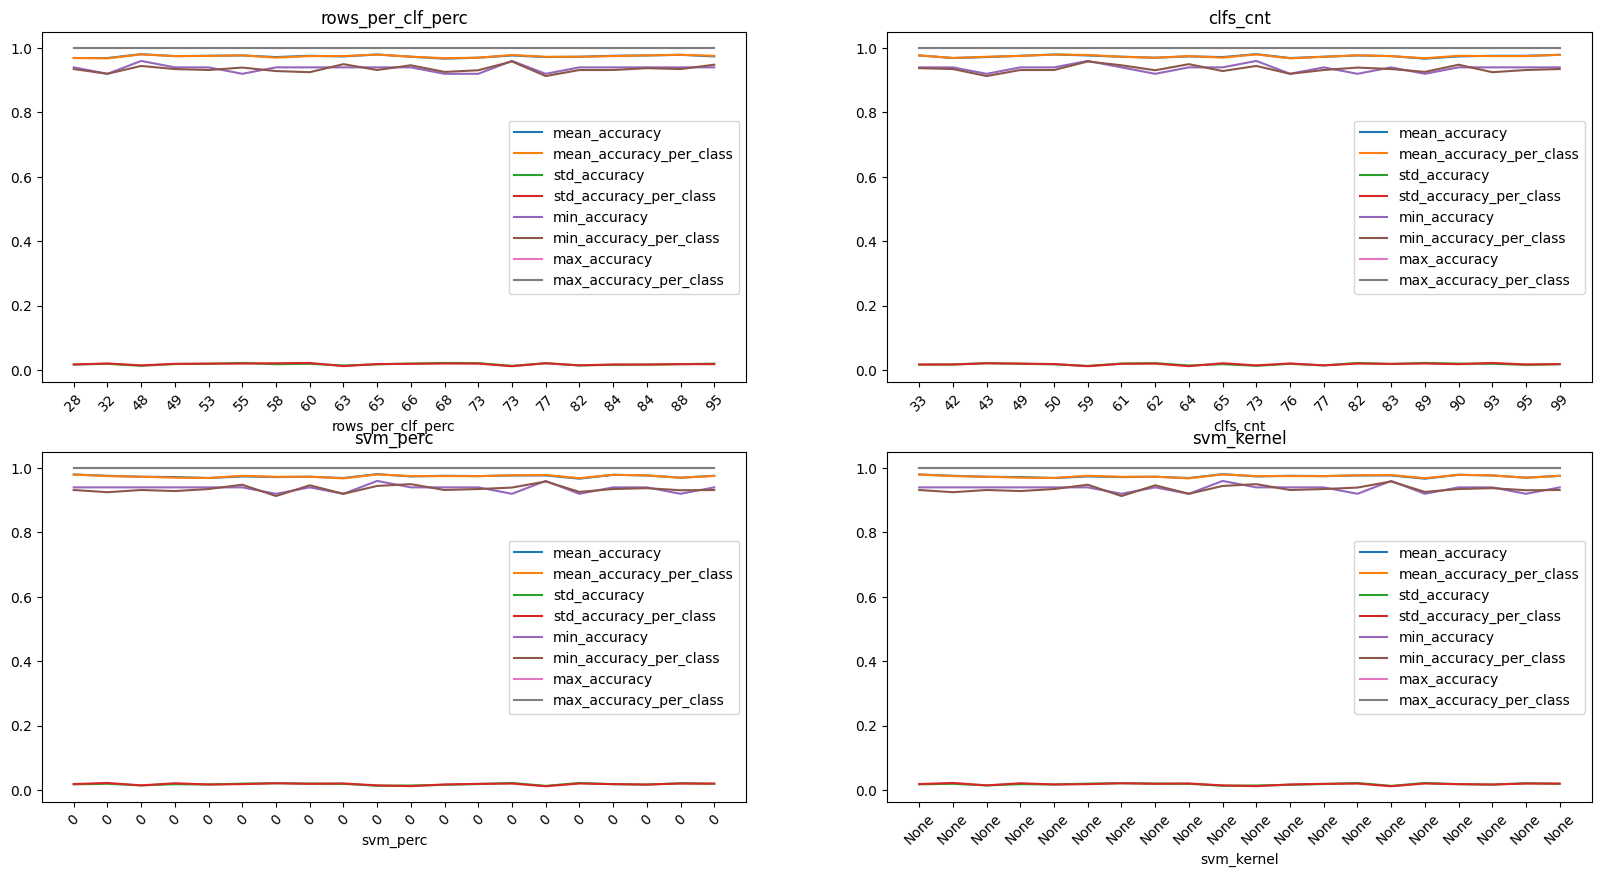

In [24]:
get_plots(df, type_='random')

## SVM

In [25]:
df = process_results(svm_results)
df = df.loc[df.dataset=='divorce', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((25, 13), 0.94076, 0.9415369214033439)

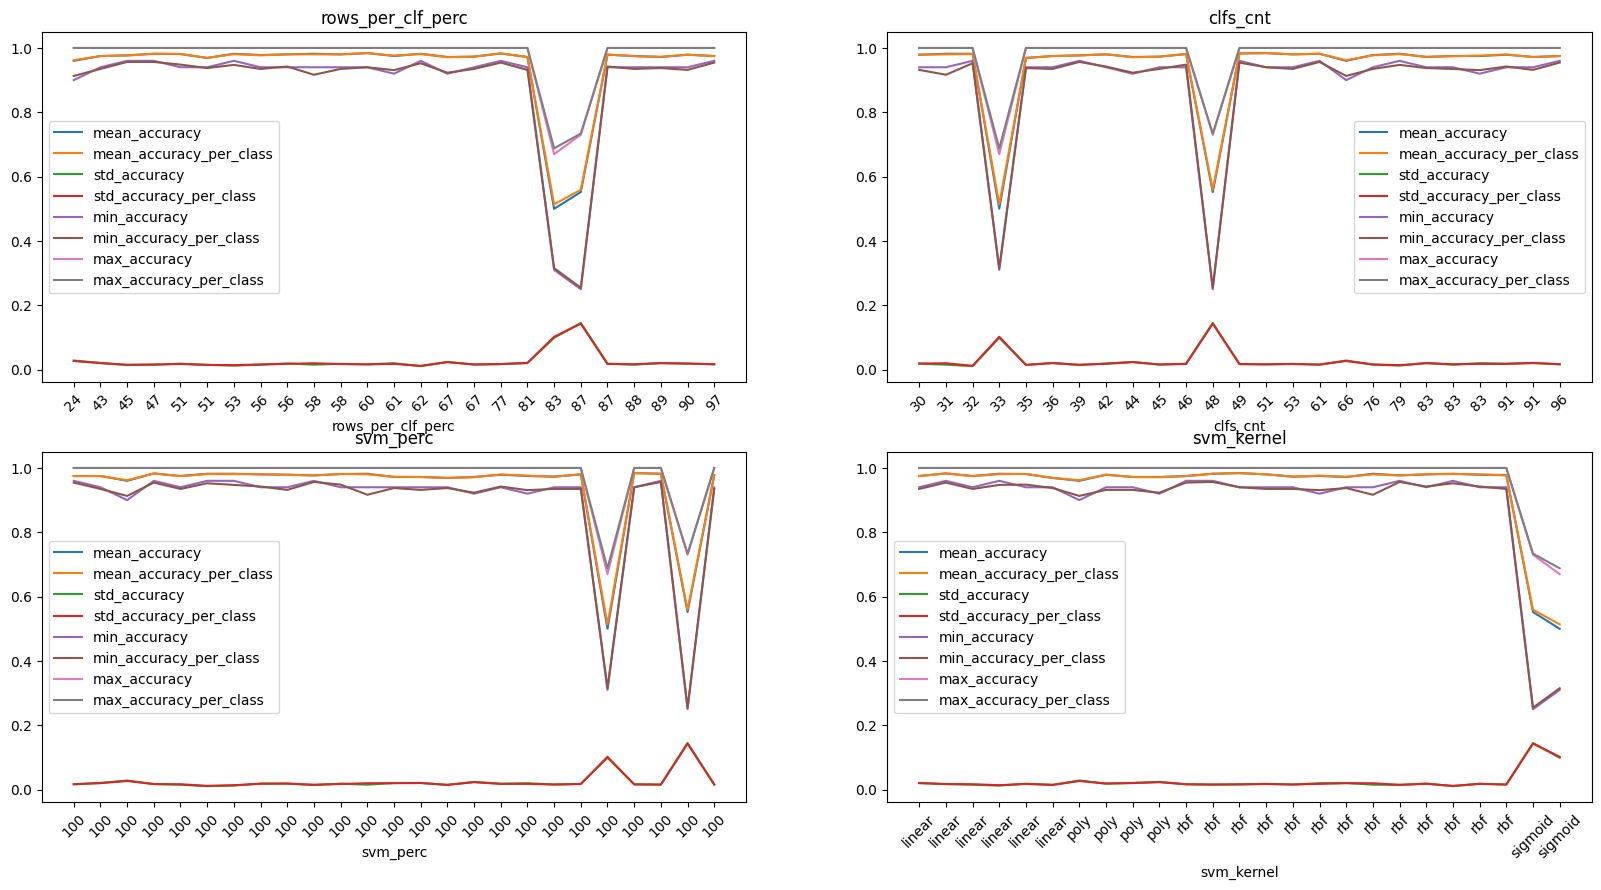

In [26]:
get_plots(df, type_='random')

## GridSearch

In [27]:
with open(os.path.join("results", "divorce", "grid_search.pickle"), "rb") as f_obj:
    divorce_results = pkl.load(f_obj)


In [28]:
df = process_results(divorce_results)
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((370, 13), 0.9596945945945946, 0.9608735494800311)

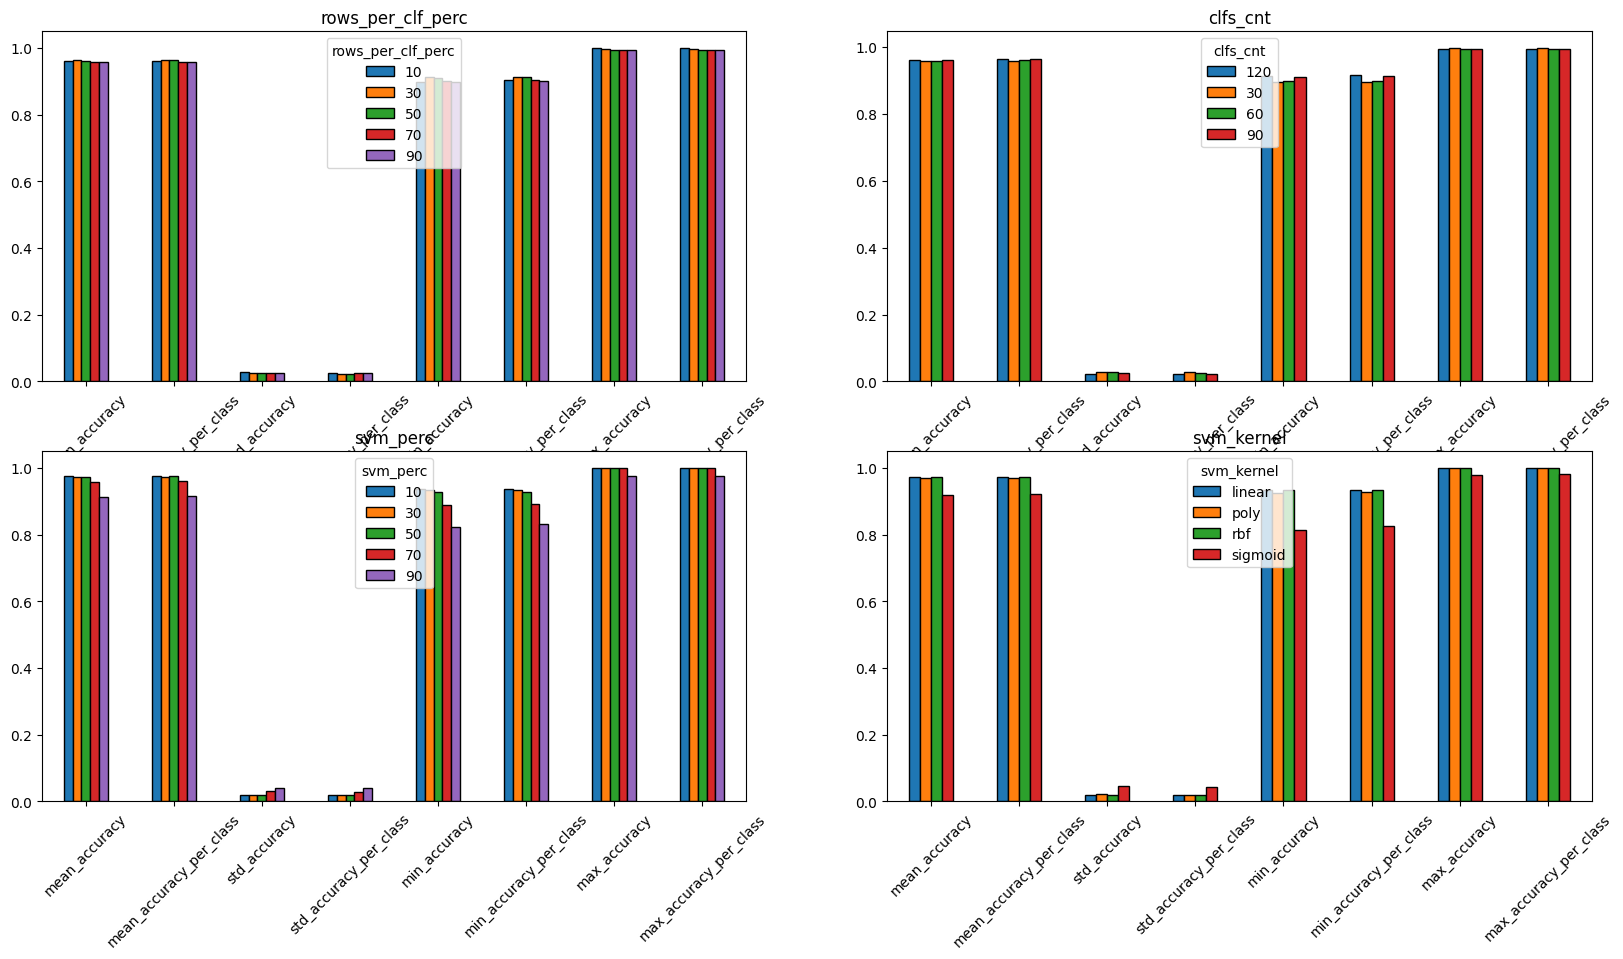

In [29]:
get_plots(df, type_='grid')

## Wyniki

W przypadku tego datasetu widoczne jest, że niezależnie od wszystkich hiperparametrów lasu losowego poza `svm_kernel` modele performują równie dobrze. Dla `svm_kernel` = sigmoid mamy znaczny spadek performance, zarówno dla zwykłego accuracy jak i dla accuracy per klasa. 
Powyższe wnioski potwierdza przeszukiwanie typu `GridSearch`: dla wszystkich hiperparametrów metryki są bardzo stabilne, jednakże dla hiperparametru `svm_kernel` widzimy, że `sigmoid` ma zauważalnie gorsze wyniki niż pozostałe opcje. Dodatkowo dla eksperymentu z lasami składającymi się wyłącznie z klasyfikatorów typu `SVM` widzimy to wyraźnie dla tego typu kernela.

# Dataset seeds

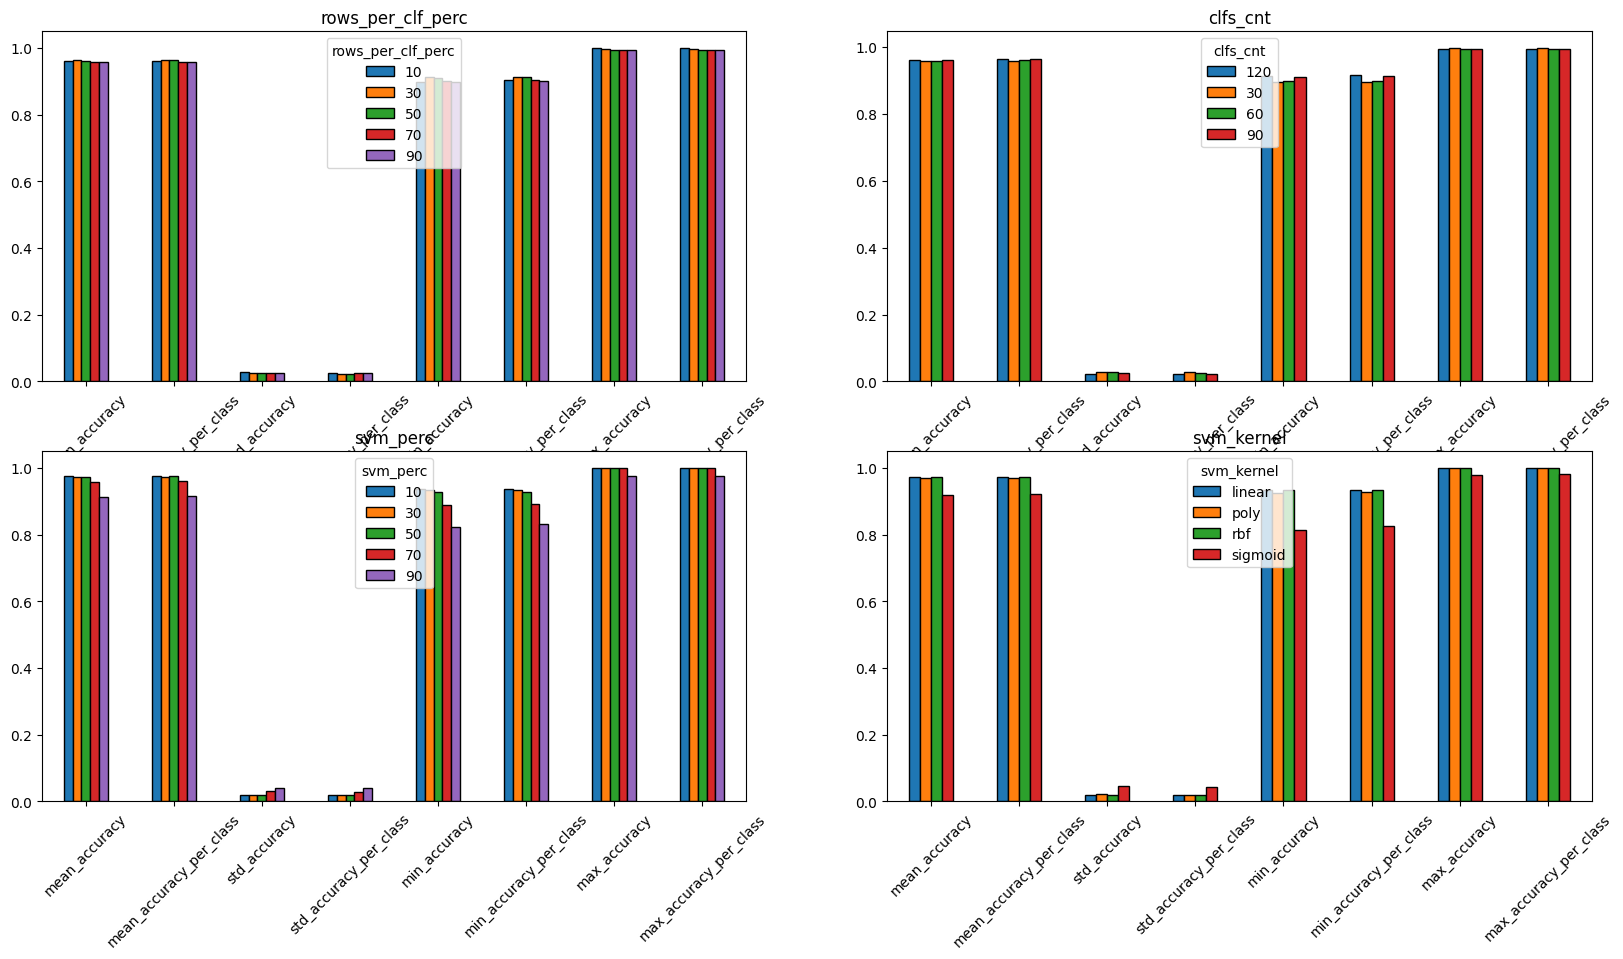

In [30]:
get_plots(df, type_='grid')

## RandomSearch

In [31]:
df = process_results(rs_results)
df = df.loc[df.dataset=='seeds', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((25, 13), 0.34418, 0.3536700207643716)

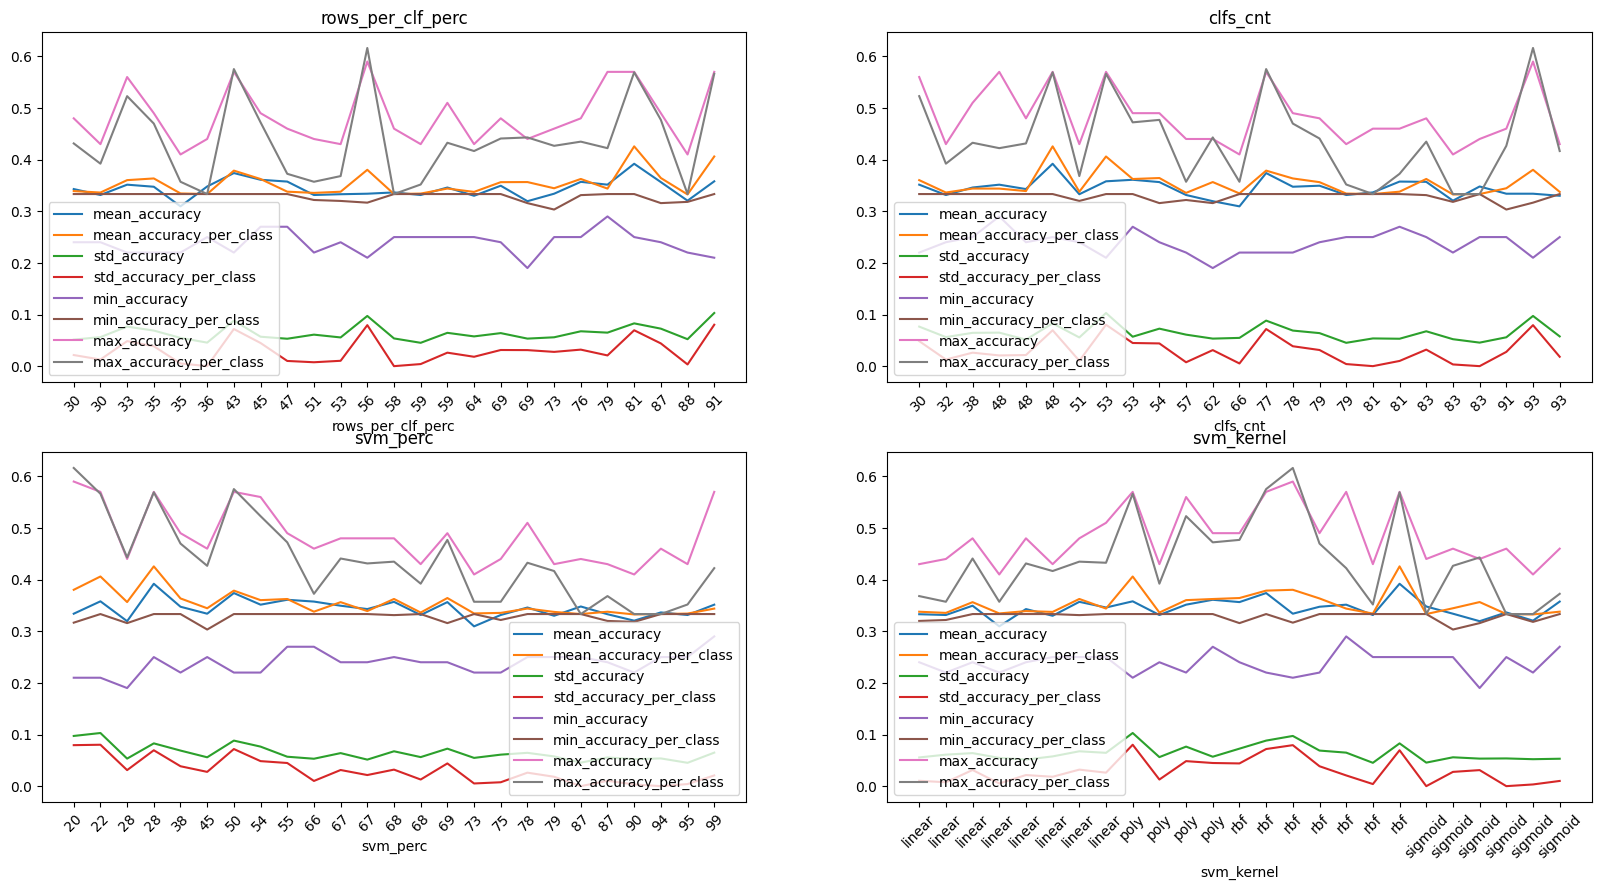

In [32]:
get_plots(df, type_='random')

## ID3

In [33]:
df = process_results(id3_results)
df = df.loc[df.dataset=='seeds', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((20, 13), 0.3304999999999999, 0.3771401821453845)

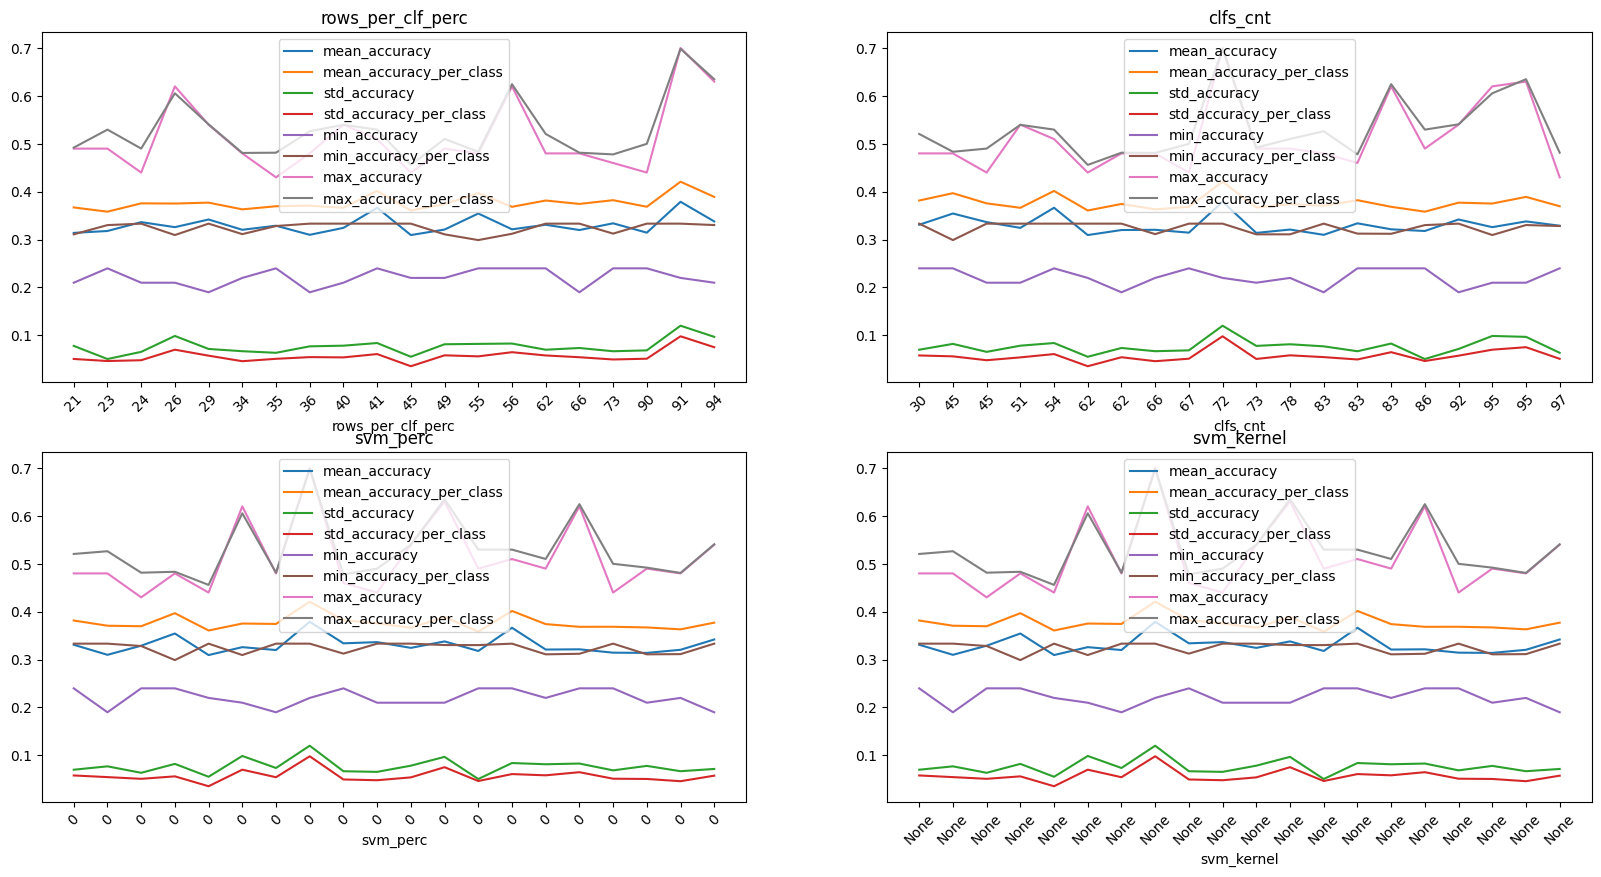

In [34]:
get_plots(df, type_='random')

## SVM

In [35]:
df = process_results(svm_results)
df = df.loc[df.dataset=='seeds', :]
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((25, 13), 0.34258000000000005, 0.3344338097348825)

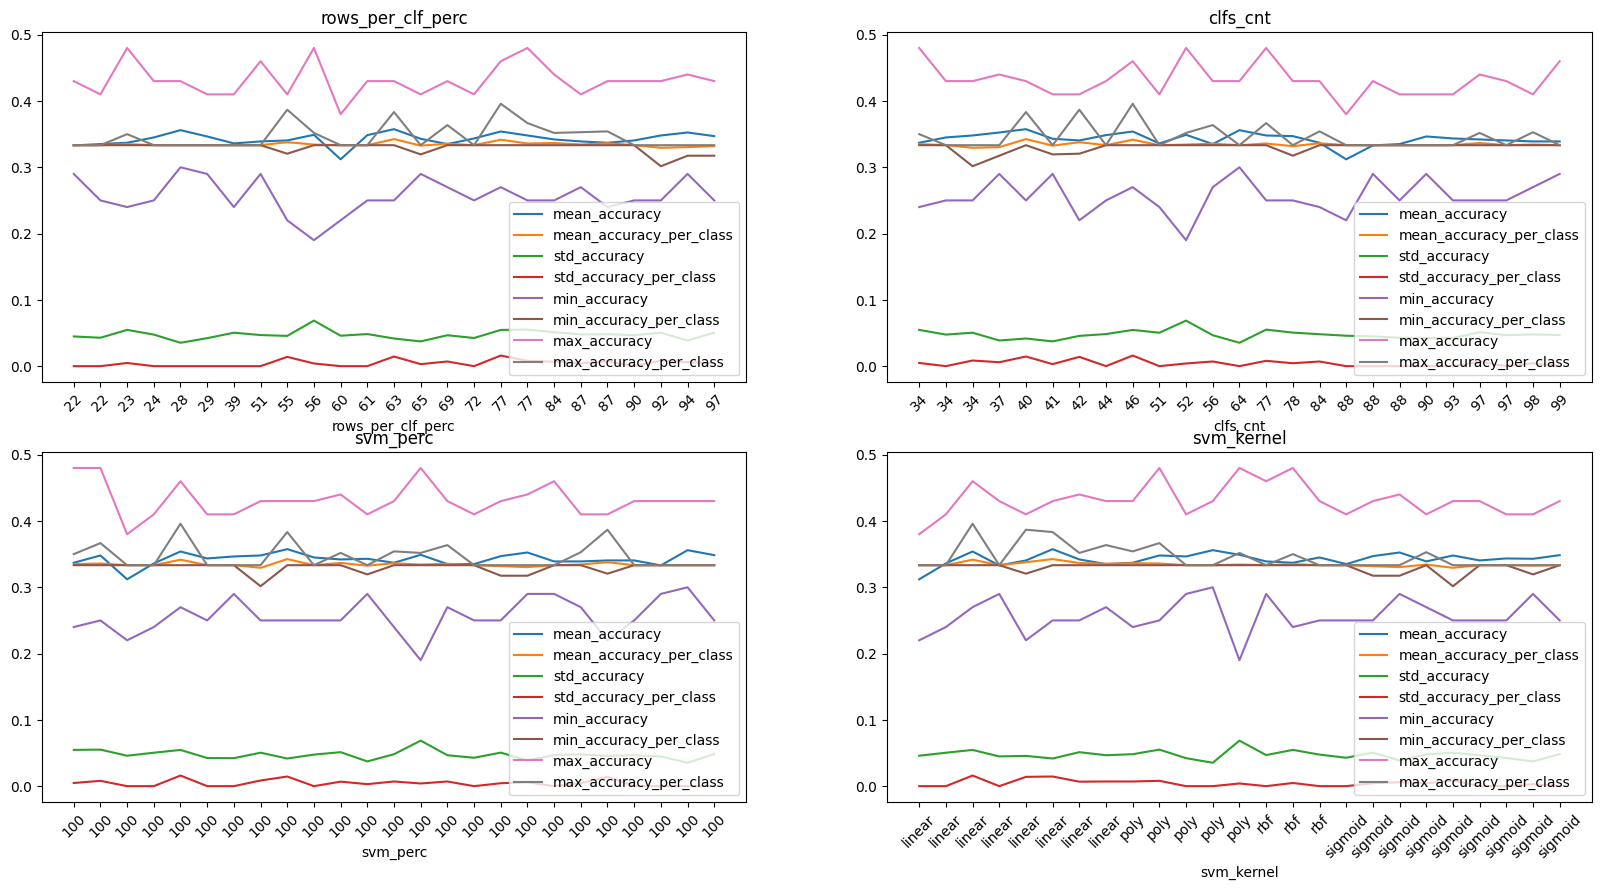

In [36]:
get_plots(df, type_='random')

## GridSearch

In [37]:
with open(os.path.join("results", "seeds", "grid_search.pickle"), "rb") as f_obj:
    seeds_results = pkl.load(f_obj)


In [38]:
df = process_results(seeds_results)
df.shape, df.mean_accuracy.mean(), df.mean_accuracy_per_class.mean()

((400, 13), 0.34036249999999996, 0.3588069778305459)

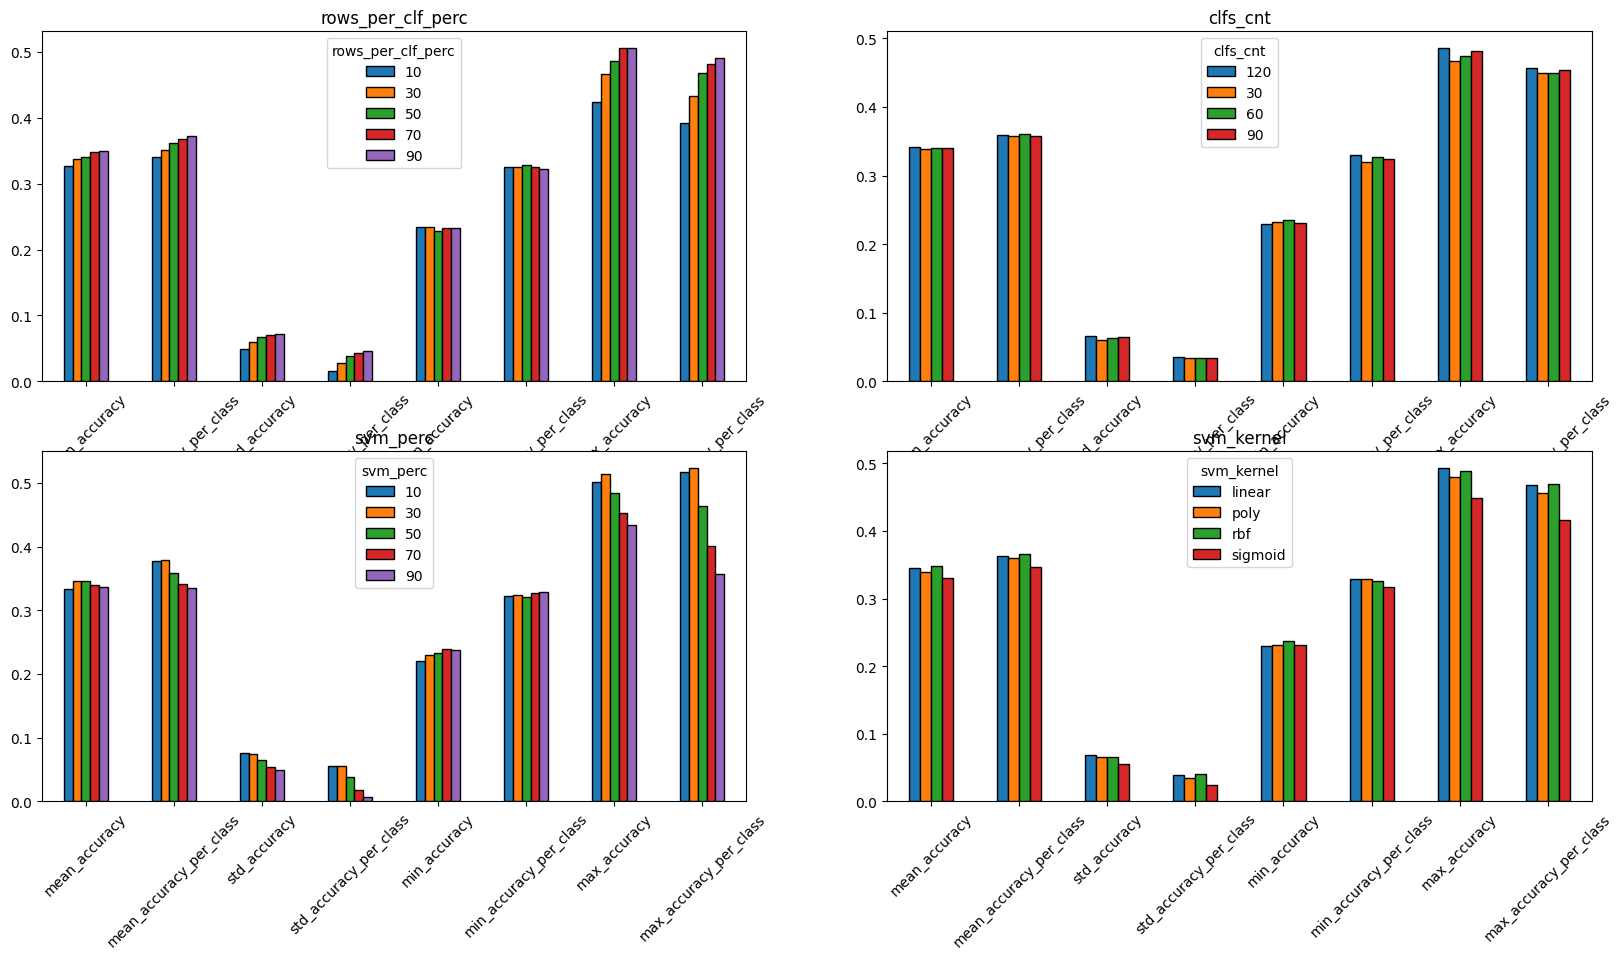

In [39]:
get_plots(df, type_='grid')

## Wyniki

Wyniki na tym zbiorze danych są najbardziej informatywne dotychczas. Widzimy, że im większy udział klasyfikatorów `SVM` w lesie tym średnio gorsze wyniki (`svm_perc`). Jesteśmy również w stanie zauważyć, że im większa część datasetu użyta była do wytrenowania pojedynczego klasyfikatora w drzewie tym lepsze wyniki lasu. Ilość klasyfikatorów nie wpływa w znaczący sposób na wyniki. 